NAME:RAVI SHANKAR V

IMS24187


Iteration 1: Split successful. Modularity: 0.0000 -> 0.4036
Iteration 2: Split successful. Modularity: 0.4036 -> 0.4107
Iteration 3: Split successful. Modularity: 0.4107 -> 0.4211

Algorithm finished after 3 successful splits.
Final modularity: 0.4211
Found 4 communities.


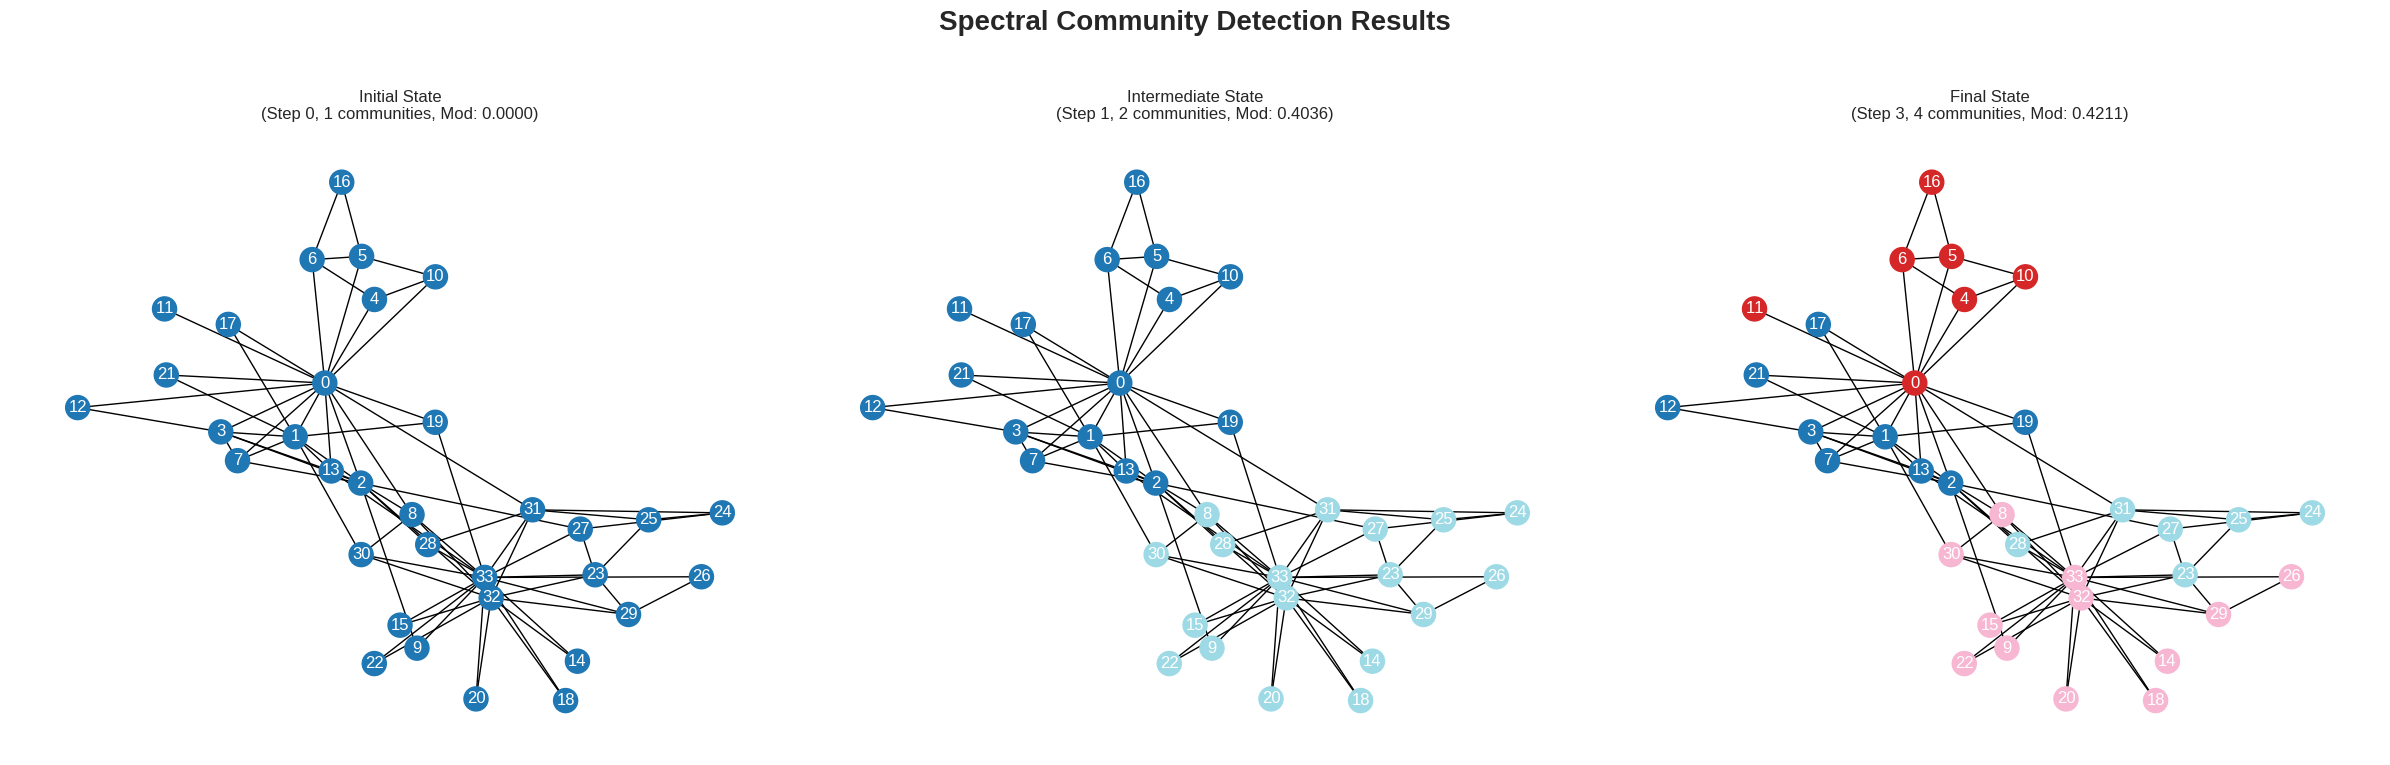

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import modularity
import math

class SpectralCommunityDetector:

    def __init__(self, G: nx.Graph):
        self.G = G
        self.A = nx.to_numpy_array(G, dtype=int)
        self.node_count = G.number_of_nodes()
        self.m = G.number_of_edges()

        self.pos = nx.spring_layout(G, seed=42)

        self.communities_history = [[set(G.nodes())]]
        self.modularity_history = [modularity(G, self.communities_history[0])]

        self.centrality_history = {
            'degree': [],
            'betweenness': [],
            'closeness': [],
            'clustering': []
        }
        self.iteration = 0

        self._record_centralities()

    def _calculate_subgraph_modularity_matrix(self, nodes_in_comm: list) -> np.ndarray:
        subG = self.G.subgraph(nodes_in_comm)
        A_c = nx.to_numpy_array(subG, nodelist=nodes_in_comm)

        k_c = np.sum(A_c, axis=1)

        m_c = k_c.sum() / 2

        if m_c == 0:
            return np.zeros_like(A_c)

        B_c = A_c - np.outer(k_c, k_c) / (2 * m_c)
        return B_c

    def _split_community(self, community: set) -> tuple | None:
        if len(community) <= 1:
            return None

        nodes_list = list(community)
        B_c = self._calculate_subgraph_modularity_matrix(nodes_list)

        try:
            eigenvalues, eigenvectors = np.linalg.eigh(B_c)
        except np.linalg.LinAlgError:
            return None

        idx = eigenvalues.argsort()[::-1]
        leading_eigenvalue = eigenvalues[idx[0]]
        leading_eigenvector = eigenvectors[:, idx[0]]

        if leading_eigenvalue < 1e-9:
            return None

        cluster_1 = set()
        cluster_2 = set()

        for i, node_index in enumerate(nodes_list):
            if leading_eigenvector[i] > 0:
                cluster_1.add(node_index)
            else:
                cluster_2.add(node_index)

        if not cluster_1 or not cluster_2:
            return None

        return cluster_1, cluster_2

    def _record_centralities(self):
        degree_cen = np.zeros(self.node_count)
        between_cen = np.zeros(self.node_count)
        close_cen = np.zeros(self.node_count)
        cluster_coeff = np.zeros(self.node_count)

        current_communities = self.communities_history[-1]

        for comm in current_communities:
            subG = self.G.subgraph(comm)

            sub_degree = nx.degree_centrality(subG)
            sub_between = nx.betweenness_centrality(subG)
            sub_close = nx.closeness_centrality(subG)
            sub_cluster = nx.clustering(subG)

            for node in comm:
                if node in sub_degree:
                    degree_cen[node] = sub_degree[node]
                    between_cen[node] = sub_between[node]
                    close_cen[node] = sub_close[node]
                    cluster_coeff[node] = sub_cluster[node]

        self.centrality_history['degree'].append(degree_cen)
        self.centrality_history['betweenness'].append(between_cen)
        self.centrality_history['closeness'].append(close_cen)
        self.centrality_history['clustering'].append(cluster_coeff)

    def run_detection(self):
        to_do_list = list(self.communities_history[0])

        while to_do_list:
            community_to_split = to_do_list.pop(0)

            proposed_split = self._split_community(community_to_split)

            if proposed_split is None:
                continue

            cluster_1, cluster_2 = proposed_split

            new_communities = list(self.communities_history[-1])
            new_communities.remove(community_to_split)
            new_communities.append(cluster_1)
            new_communities.append(cluster_2)

            new_mod = modularity(self.G, new_communities)
            current_mod = self.modularity_history[-1]

            if new_mod > current_mod:
                self.iteration += 1
                print(f"Iteration {self.iteration}: Split successful. Modularity: {current_mod:.4f} -> {new_mod:.4f}")

                self.communities_history.append(new_communities)
                self.modularity_history.append(new_mod)

                to_do_list.append(cluster_1)
                to_do_list.append(cluster_2)

                self._record_centralities()

        print(f"\nAlgorithm finished after {self.iteration} successful splits.")
        print(f"Final modularity: {self.modularity_history[-1]:.4f}")
        print(f"Found {len(self.communities_history[-1])} communities.")

    def _get_color_map(self, step: int) -> list:
        color_map = {}
        communities = self.communities_history[step]
        for i, comm in enumerate(communities):
            for node in comm:
                color_map[node] = i

        colors = [color_map.get(node, -1) for node in self.G.nodes()]
        return colors

    def plot_graph_state(self, step: int, ax: plt.Axes, title: str):
        if step == -1:
            step = self.iteration

        colors = self._get_color_map(step)
        num_communities = len(self.communities_history[step])
        mod = self.modularity_history[step]

        nx.draw(
            self.G,
            pos=self.pos,
            ax=ax,
            with_labels=True,
            node_color=colors,
            cmap=plt.cm.tab20,
            font_color='white'
        )
        ax.set_title(f"{title}\n(Step {step}, {num_communities} communities, Mod: {mod:.4f})")

    def show_results(self):
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))

        self.plot_graph_state(0, axes[0], "Initial State")

        if self.iteration > 1:
            mid_step = self.iteration // 2
            self.plot_graph_state(mid_step, axes[1], "Intermediate State")
        else:
            axes[1].set_title("Intermediate State\n(Not enough iterations to show)")
            axes[1].axis('off')

        self.plot_graph_state(-1, axes[2], "Final State")

        fig.suptitle("Spectral Community Detection Results", fontsize=20, weight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

if __name__ == "__main__":

    G = nx.karate_club_graph()

    detector = SpectralCommunityDetector(G)

    detector.run_detection()

    detector.show_results()

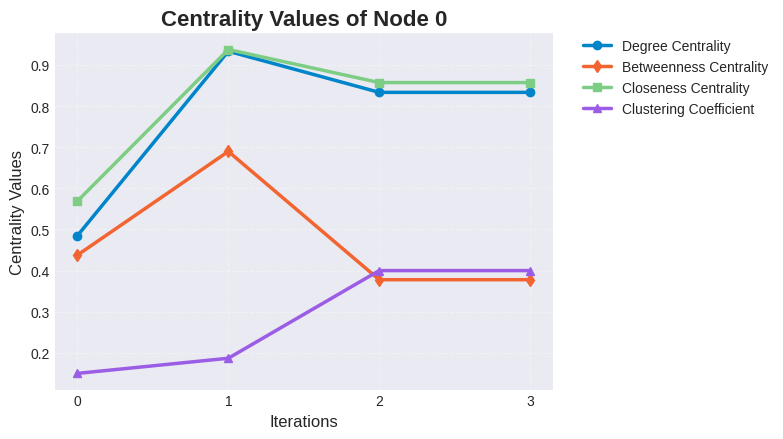

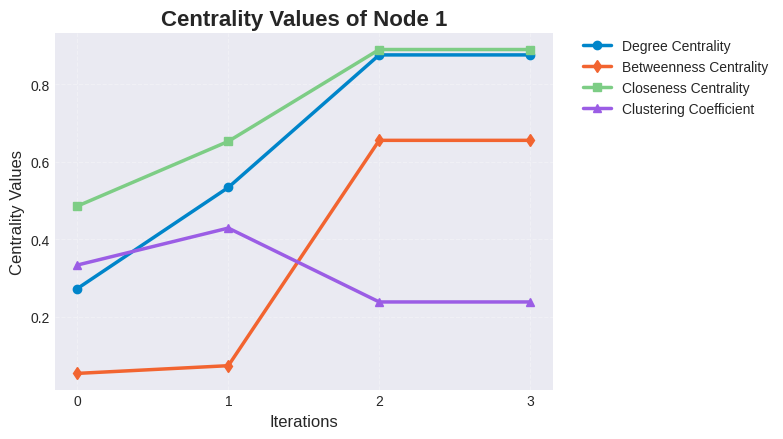

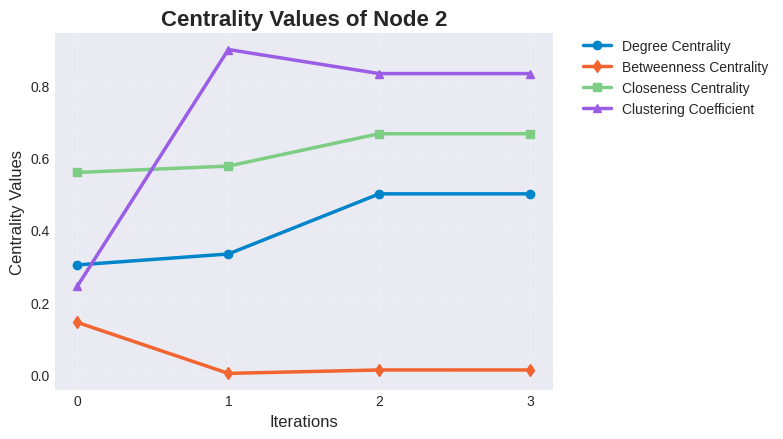

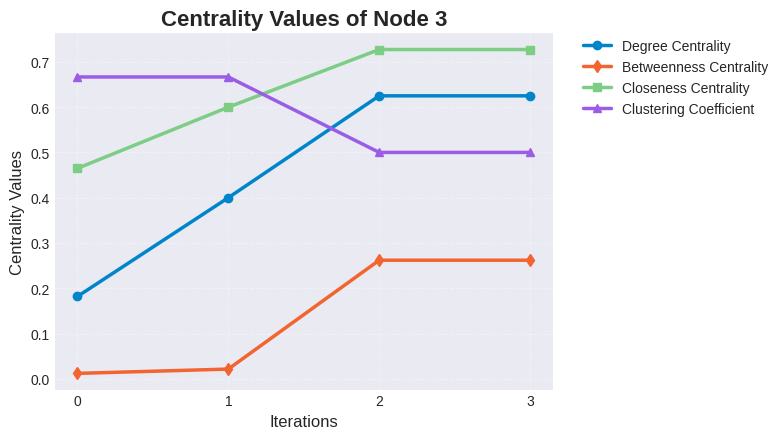

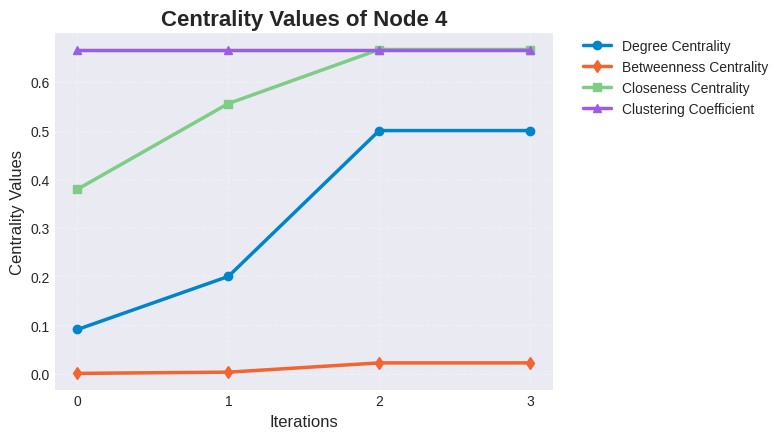

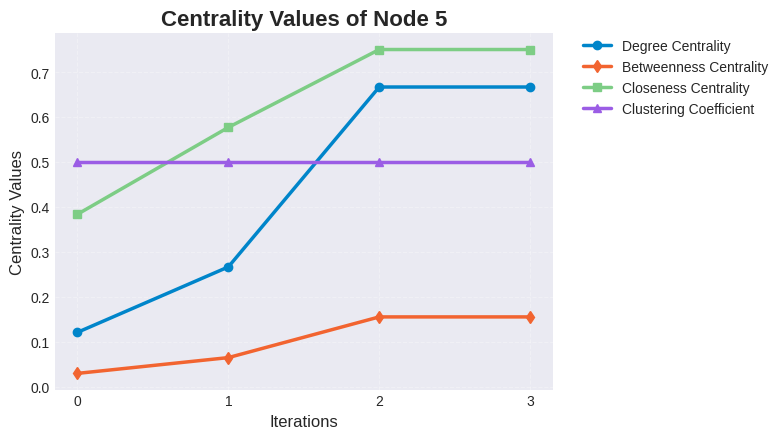

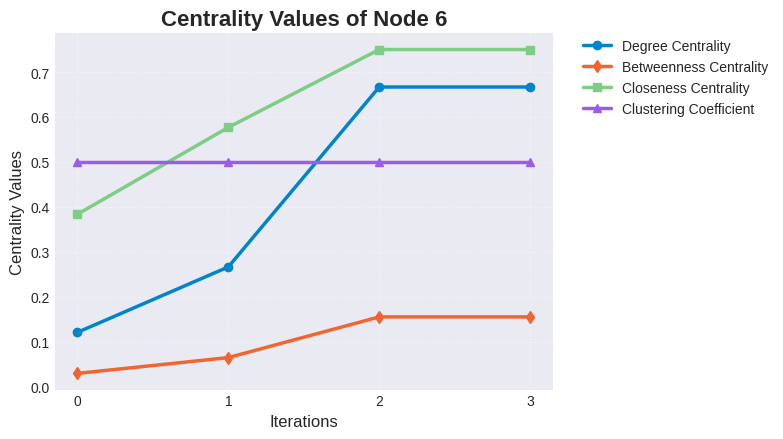

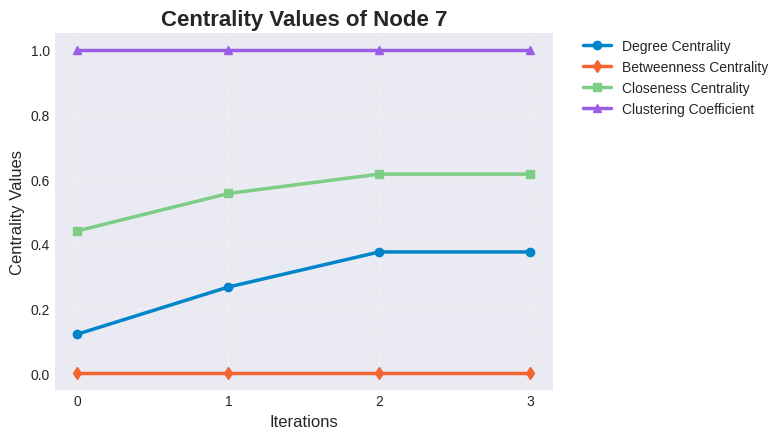

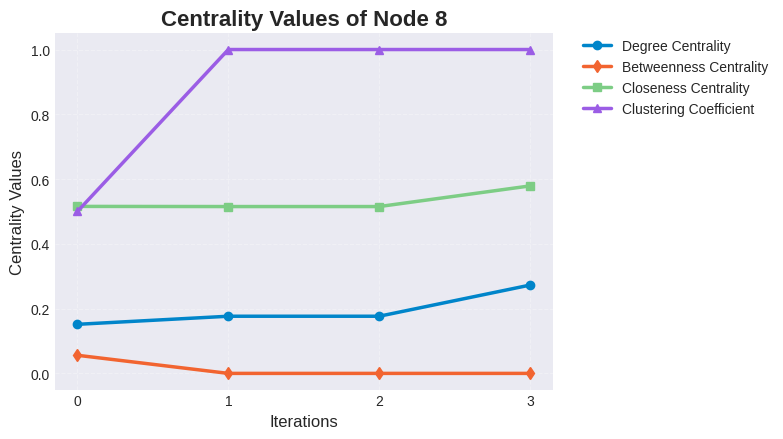

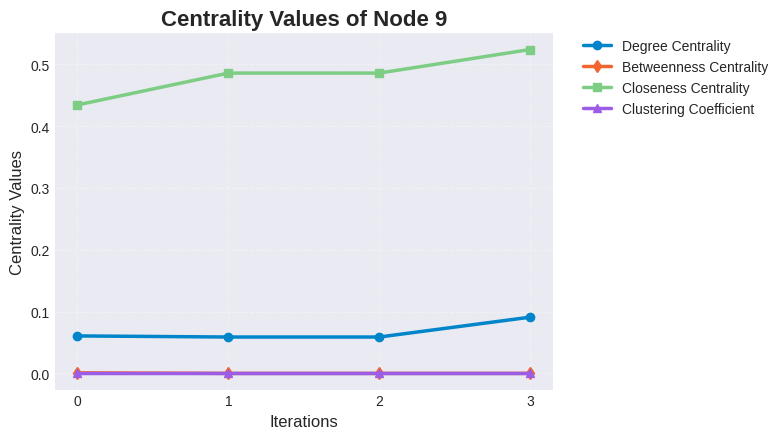

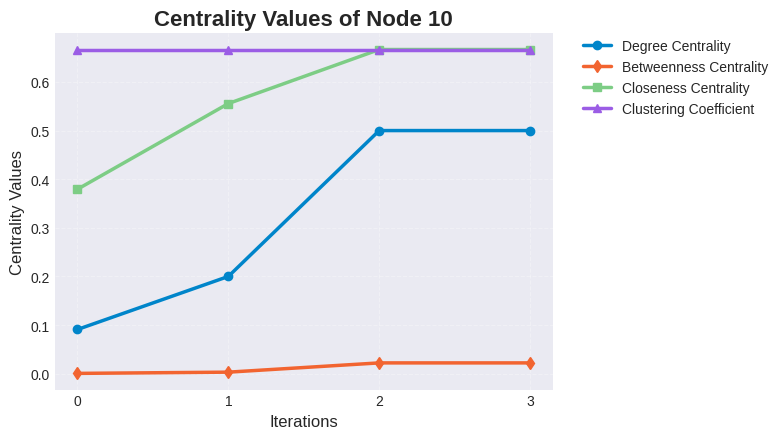

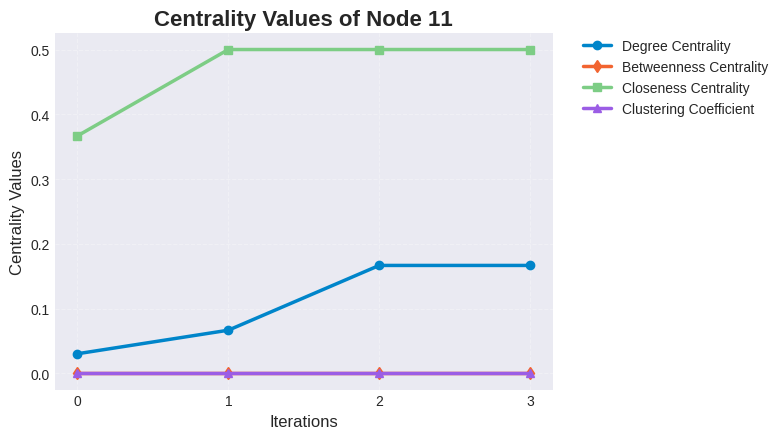

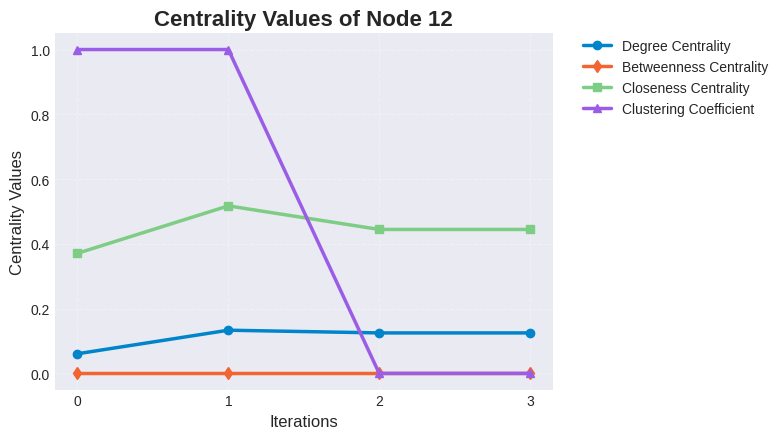

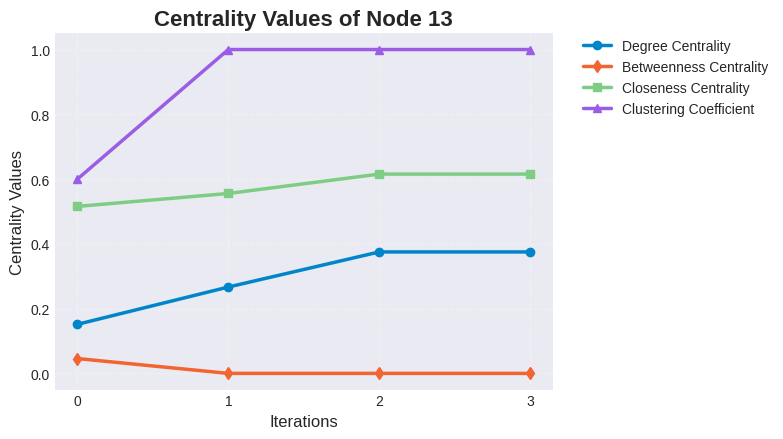

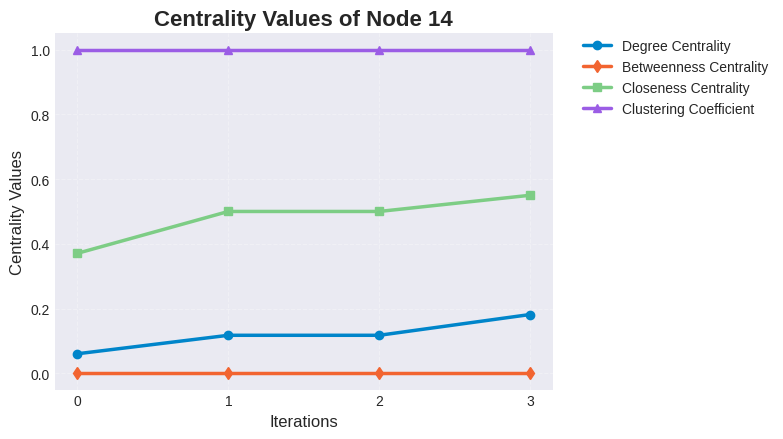

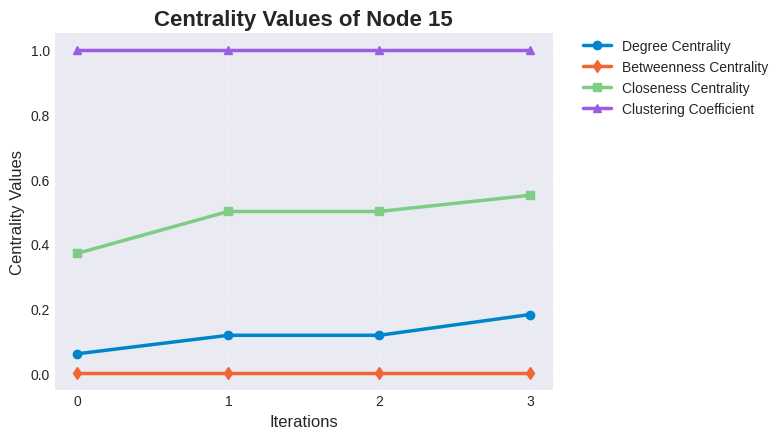

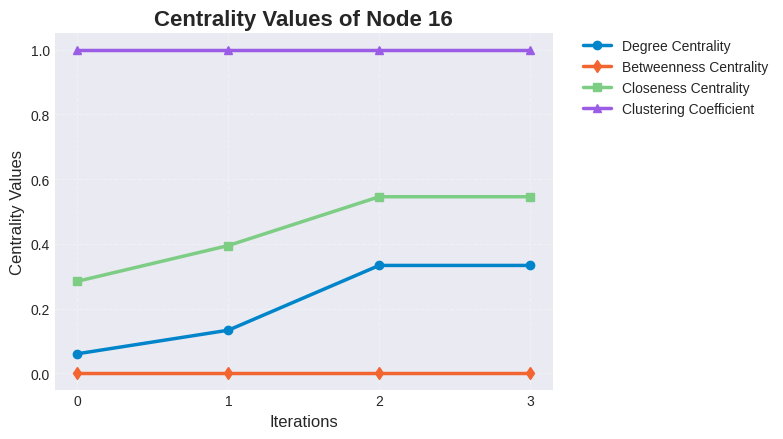

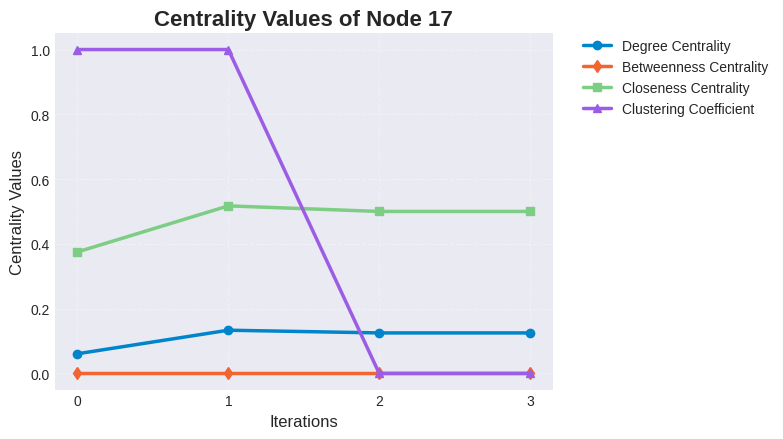

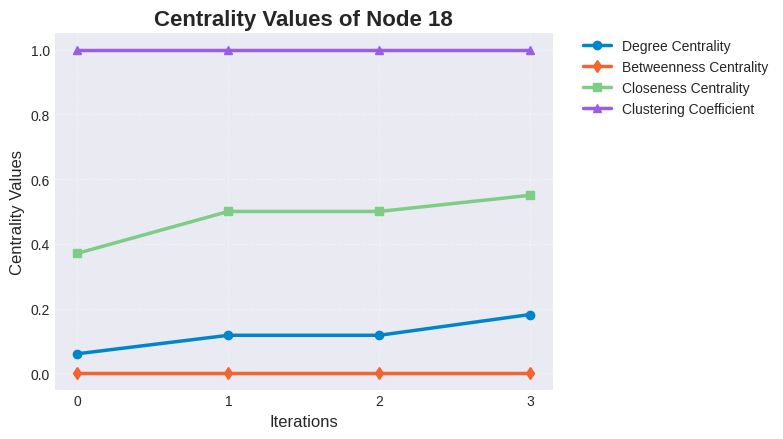

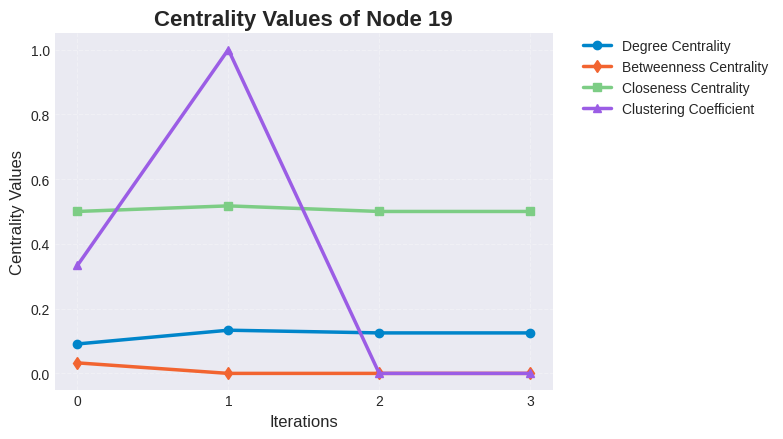

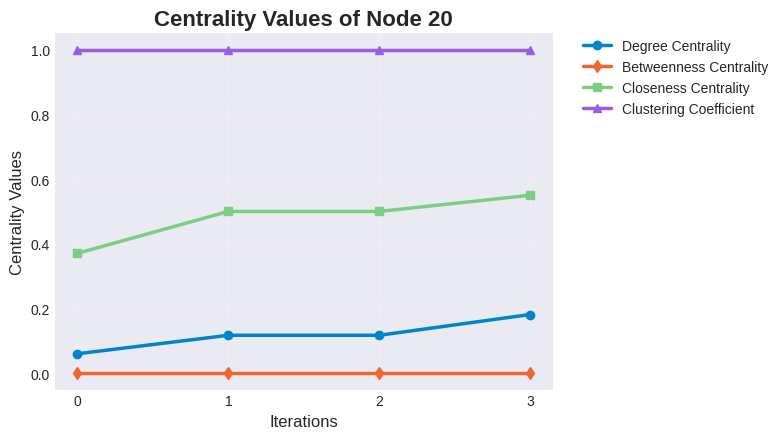

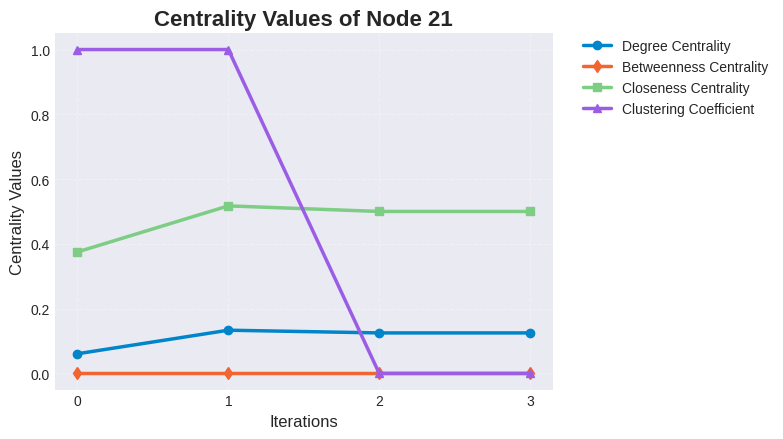

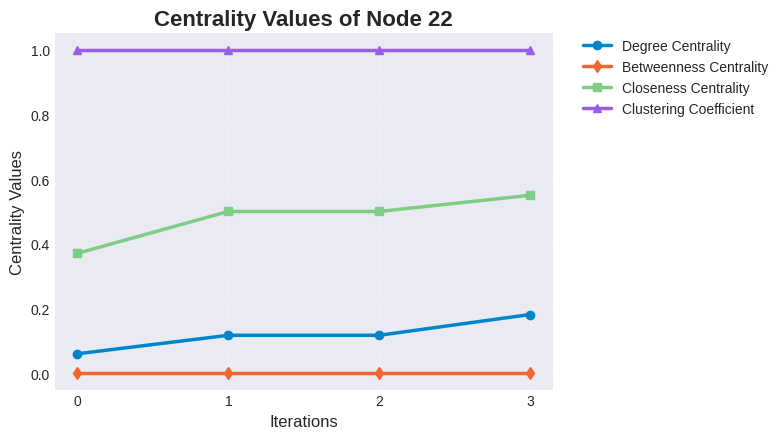

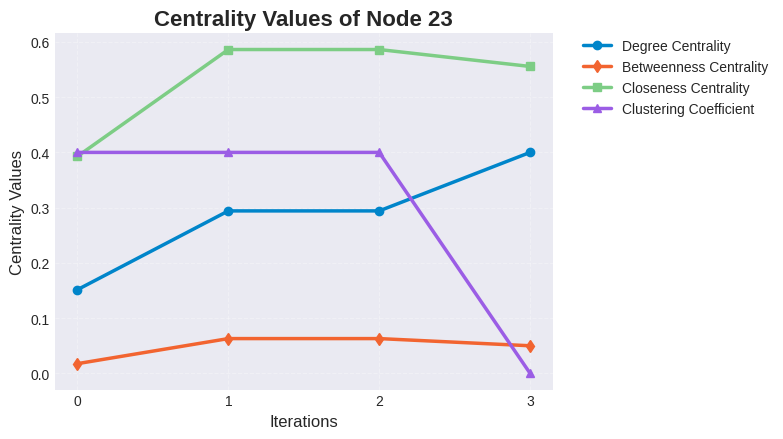

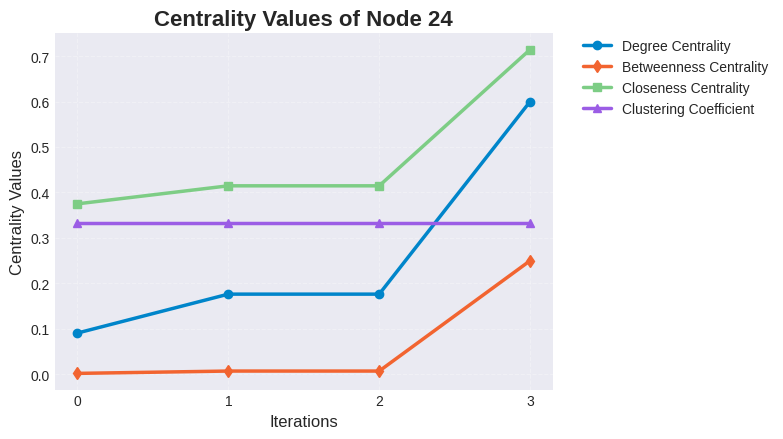

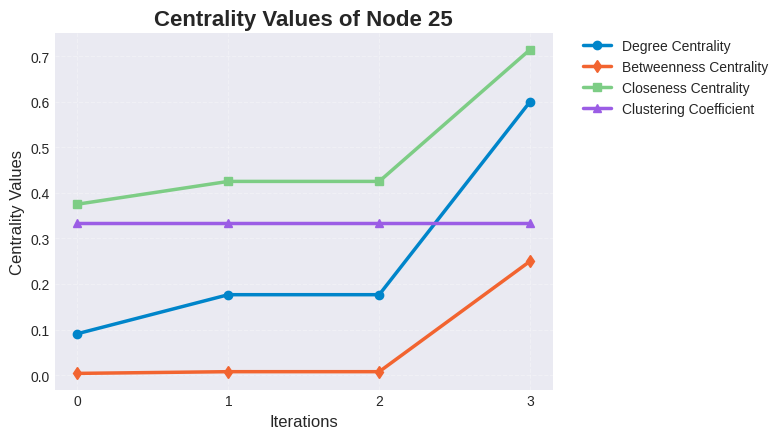

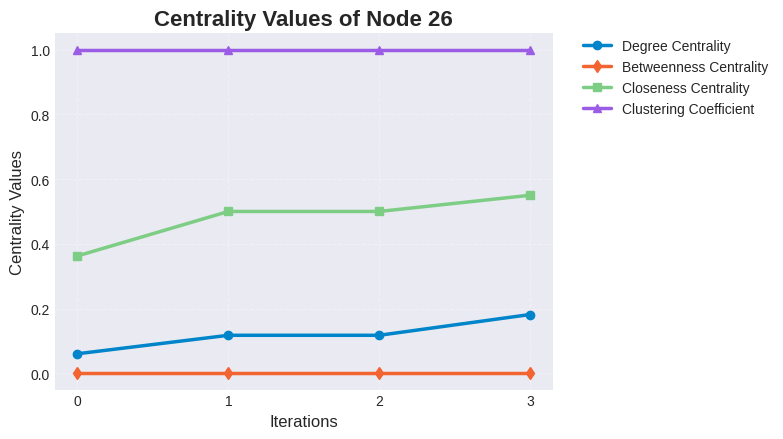

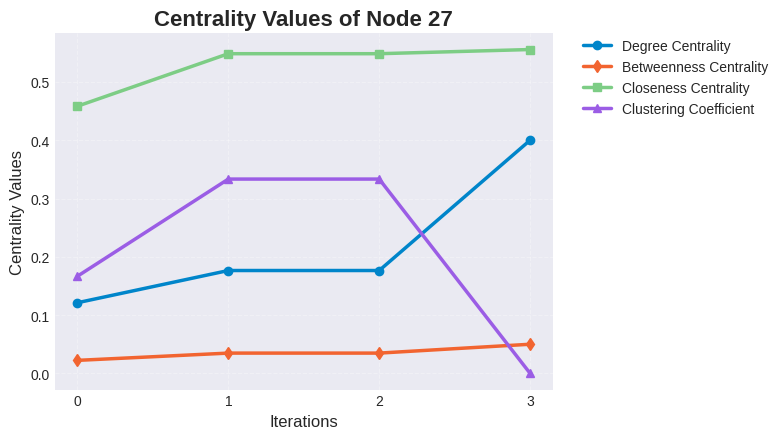

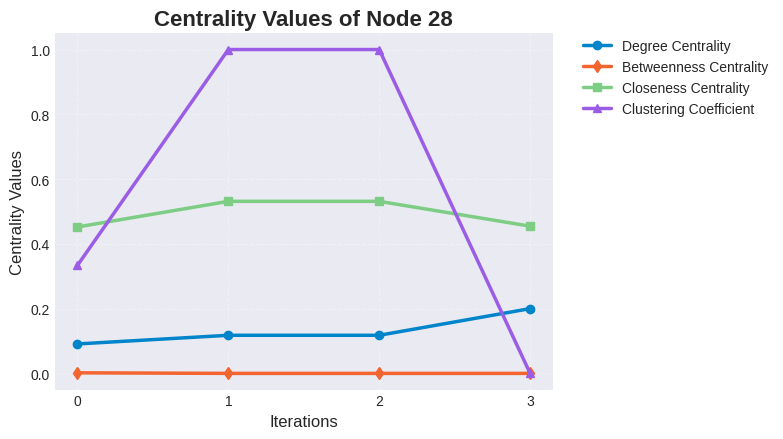

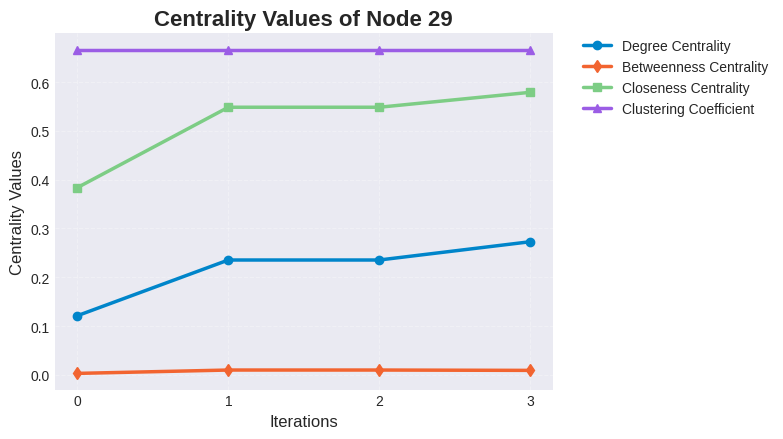

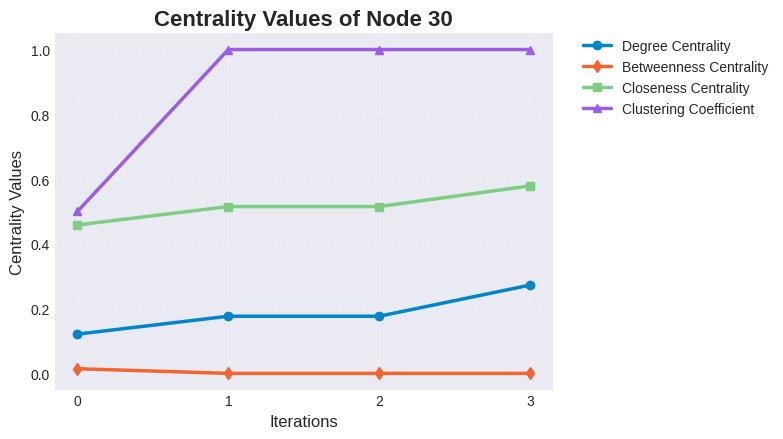

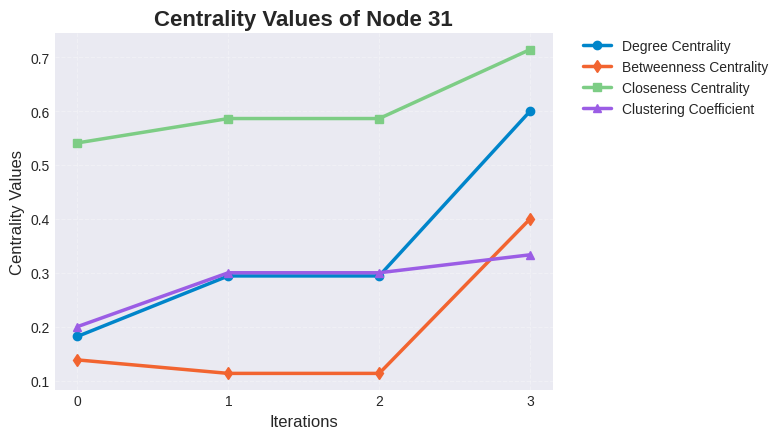

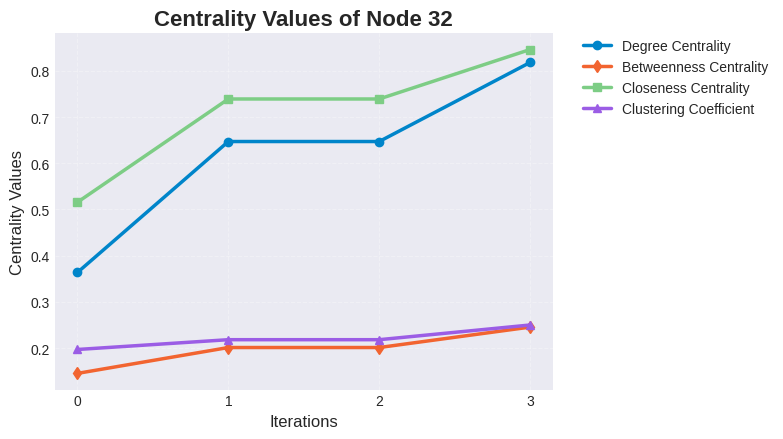

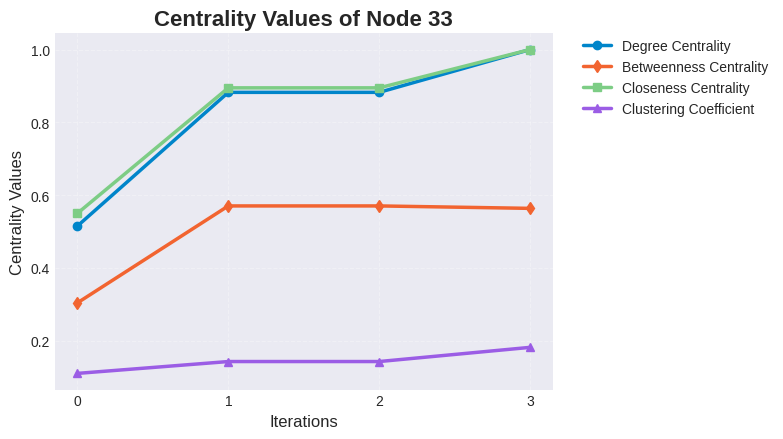

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

colors = ['#0085CA', '#F26430', '#7DCD85', '#9B5DE5']

num_iters = detector.iteration
num_nodes = detector.node_count

iters_range = list(range(0, num_iters + 1, 1))

degree_hist = detector.centrality_history['degree']
betweenness_hist = detector.centrality_history['betweenness']
closeness_hist = detector.centrality_history['closeness']
clustering_hist = detector.centrality_history['clustering']

for i in range(num_nodes):
    degree_vals = []
    betweenness_vals = []
    closeness_vals = []
    clustering_vals = []
    for j in range(num_iters + 1):
        degree_vals.append(degree_hist[j][i])
        betweenness_vals.append(betweenness_hist[j][i])
        closeness_vals.append(closeness_hist[j][i])
        clustering_vals.append(clustering_hist[j][i])

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(alpha=0.3, linestyle='--')

    ax.plot(iters_range, degree_vals, label='Degree Centrality', color=colors[0], linewidth=2.5, marker='o')
    ax.plot(iters_range, betweenness_vals, label='Betweenness Centrality', color=colors[1], linewidth=2.5, marker='d')
    ax.plot(iters_range, closeness_vals, label='Closeness Centrality', color=colors[2], linewidth=2.5, marker='s')
    ax.plot(iters_range, clustering_vals, label='Clustering Coefficient', color=colors[3], linewidth=2.5, marker='^')

    ax.set_title(f'Centrality Values of Node {i}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Iterations', fontsize=12)
    ax.set_ylabel('Centrality Values', fontsize=12)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=10)
    plt.tight_layout()
    plt.show()